In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import os 
import yaml 
import glob 
import pandas as pd
from burst import *
import openpyxl

class LabelAnalysis():

    def __init__(self, video_name):
        self.video_name = video_name 
        self.__path = r'C:\Users\jyc13\Documents\Python Scripts\openCV_eyemovement\yolov5\runs\detect\{0}\labels'.format(video_name)
        self.__object_classes = yaml.safe_load(open('object_classes.yaml', 'r'))
        self.read_video_info()
        self.check_video_name()

        self.__video_w = int(self.this_info['FrameWidth']) # 가로 resolution
        self.__video_h = int(self.this_info['FrameHeight']) # 세로 resolution
        self.__video_fps = float(self.this_info['FPS']) # frame per second
        self.__start_frame = int(self.this_info['StartFrame'])
        self.__end_frame = int(self.this_info['EndFrame'])
        # need to update
        # self.__pixelpermm = 10.2 # pixel/mm 
    
    @property
    def get_start_frame(self):
        return self.__start_frame
    
    @property 
    def get_end_frame(self):
        return self.__end_frame

    def read_video_info(self):
        file_path = "D:\Research\SC\DATA\Eye_Movement\VideoInfo.csv"
        self.video_info = pd.read_csv(file_path)
    
    def check_video_name(self):
        _this_info = self.video_info[self.video_info['Frequency'] == 20]
        _this_video_names = _this_info['VideoName']
        if (_this_video_names.str.contains(self.video_name.lower(), case=False).any()) == True:
            self.this_info = self.video_info.loc[self.video_info['VideoName'].str.lower() == self.video_name.lower(), :]
            display(self.this_info)
        else: 
            raise Exception(f"There is no file named {self.video_name}.")

    def read_labels(self):
        # YOLO style: (num_class center_x center_y w, h \n) 모든 값은 resoluion 기준으로 비율
        
        # read all txt files in the __path
        files = glob.glob(f'{self.__path}/*.txt')
        data = []
        for file in files:
            n_frame = int(file.split('_')[-1].replace('.txt', ''))
            if (n_frame >= self.__start_frame) & (n_frame <= self.__end_frame):
                with open(file, 'rt') as f:
                    lines = f.readlines()
                    for line in lines:
                        splited = line.split(' ')
                        num_class = int(splited[0])
                        class_name = str(self.__object_classes[num_class])
                        # pixel 단위로 변환
                        center_x = float(splited[1]) * self.__video_w 
                        center_y = float(splited[2]) * self.__video_h 
                        w = float(splited[3]) * self.__video_w 
                        h = float(splited[4]) * self.__video_h 
                        size = w * h # size는 width * height 직사각형이라고 가정

                        frame_data = [n_frame, num_class, class_name, center_x, center_y, w, h, size]
                        data.append(frame_data)
            else:
                pass 

        # format Dataframe
        df = pd.DataFrame(data)
        df.rename(columns = {0:'n_frame'}, inplace = True)
        df.rename(columns = {1:'num_class'}, inplace = True)
        df.rename(columns = {2:'class_name'}, inplace = True)
        df.rename(columns = {3:'center_x'}, inplace = True)
        df.rename(columns = {4:'center_y'}, inplace = True)
        df.rename(columns = {5:'width'}, inplace = True)
        df.rename(columns = {6:'height'}, inplace = True)
        df.rename(columns = {7:'size'}, inplace = True)

        df.sort_values(by=['n_frame', 'num_class'], inplace=True, ignore_index=True)

        # interpolation
        def interpol(df):
            idx = range(self.__start_frame, self.__end_frame + 1)
            idx_df = pd.DataFrame(idx, columns=['idx_frame'])

            eye_df = df[df['class_name'] == 'eye']
            pupil_df = df[df['class_name'] == 'pupil']

            eye_df2 = idx_df.merge(eye_df, left_on='idx_frame', right_on='n_frame', how='outer')
            pupil_df2 = idx_df.merge(pupil_df, left_on='idx_frame', right_on='n_frame', how='outer')
            
            eye_df2.loc[eye_df2['num_class'].isna(), 'num_class'] = 0
            eye_df2.loc[eye_df2['class_name'].isna(), 'class_name'] = 'eye'
            pupil_df2.loc[pupil_df2['num_class'].isna(), 'num_class'] = 1 
            pupil_df2.loc[pupil_df2['class_name'].isna(), 'class_name'] = 'pupil'

            eye_df3 = eye_df2.interpolate(method='linear', limit_direction='both')
            pupil_df3 = pupil_df2.interpolate(method='linear', limit_direction='both')

            concated_df = pd.concat([eye_df3, pupil_df3], ignore_index=True)

            return concated_df 
        
        df = interpol(df)

        # diff
        df['pupil-eye_x'] = df.groupby(by=['n_frame'])['center_x'].diff()
        df['pupil-eye_y'] = df.groupby(by=['n_frame'])['center_y'].diff()

        # Time code
        df['time_code'] = df['n_frame'] / self.__video_fps # return time code

        return df 
    
    def get_onoff(self):
        mouse = Burst(video_name=self.video_name)
        df_onoff = mouse.get_stim_on_frames()

        return df_onoff

    def merge_df(self):
        df_base = self.read_labels()
        df_onoff = self.get_onoff()
        df_merge = df_base.merge(df_onoff, on=['n_frame'])

        return df_merge

    def get_result_df(self):
        df_res = self.merge_df()

        return df_res
    
    def get_stim_range_list(self):
        df_res = self.merge_df()

        range_list = []
        prev_val = False

        for inx, val in df_res['stim'].iteritems():
            if prev_val != val:
                if val:
                    start = df_res.loc[inx, 'n_frame']
                else:
                    range_list.append((start, df_res.loc[inx, 'n_frame']))

            prev_val = val
            
        return range_list

    def get_peth(self):
        res_df = self.get_result_df()
        range_list = self.get_stim_range_list()
        
        x_span = 180
        peth = []
        n_cycle = 0

        for (start, end) in range_list:
            if (start >= x_span) & (end <= max(res_df['n_frame']) - x_span):
                tmp = res_df.copy()
                tmp['peth_frame'] = tmp['n_frame'] - start
                tmp = tmp.loc[(tmp['peth_frame'] >= -x_span) & (tmp['peth_frame'] <= x_span)]
                tmp.loc[:, 'n_cycle'] = n_cycle
                n_cycle += 1
                peth.append(tmp)

        df_peth = pd.concat(peth)

        return df_peth

    def draw_peth(self, x='peth_frame', y='pupil-eye_x', hue='stim'):
        df_peth = self.get_peth()
        if y == 'pupil-eye_x' or 'pupil_eye_y':
            df_plot = df_peth.dropna()
        else:
            df_plot = df_peth

        fig_peth = sns.lineplot(x='peth_frame', y=y, hue='stim', data=df_plot) # std span 보기 위해
        plt.show()

        return fig_peth
    
    def save_peth_fig(self, save_path=r'./result_fig'):
        fig = self.draw_peth().figure
        save_name = self.video_name + '.png'
        fig.savefig(os.path.join(save_path, save_name))
    
    def peth_to_xlsx(self, save_path=r'./result_xlsx'):
        df_peth = self.get_peth()
        save_name = self.video_name + '.xlsx'
        df_peth.to_excel(os.path.join(save_path, save_name))


In [2]:
# list filenames to run analysis
detect_path = r'C:\Users\jyc13\Documents\Python Scripts\openCV_eyemovement\yolov5\runs\detect'
filenames = [x for x in os.listdir(detect_path) if '20hz' in x]
print(len(filenames))

24


,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
4,Left,1,31,31 L 20hz 5ms 5s.mp4,1,20.0,1,16000,17385.0,17684.0,59.94,1920,1080


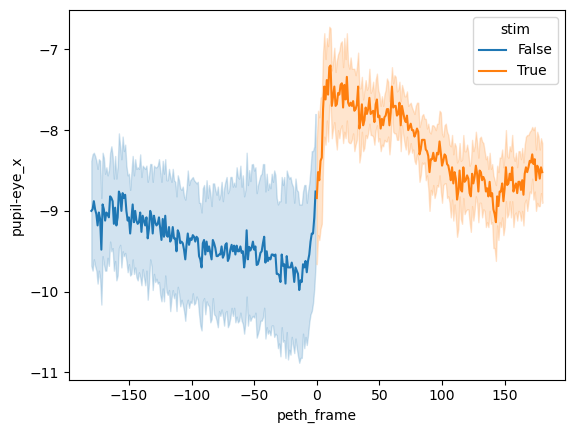

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
7,Right,1,31,31 R 20hz 5ms 5s.mp4,0,20.0,1,16000,17385.0,17684.0,59.94,1920,1080


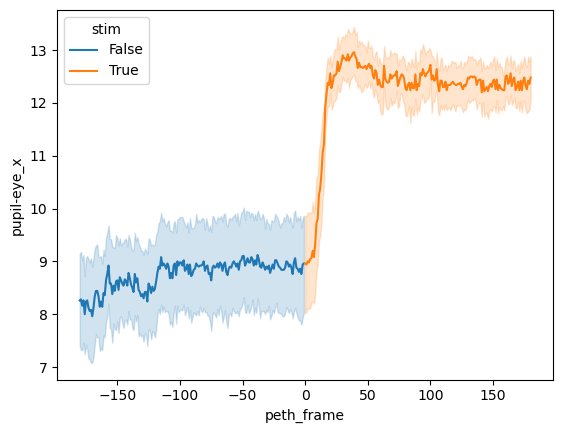

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
10,Left,1,32,32 L 20hz 5ms 5s.mp4,1,20.0,1,16000,17385.0,17684.0,59.94,1920,1080


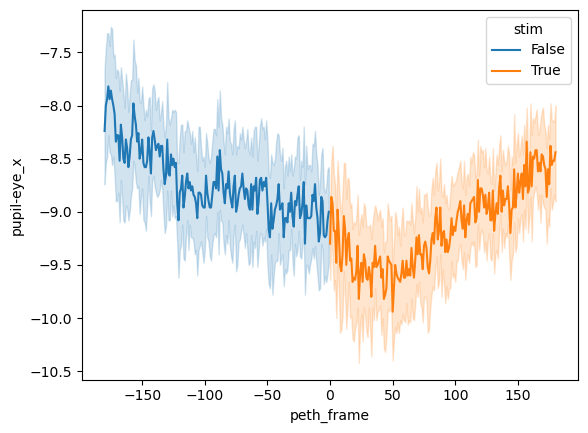

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
11,Right,1,32,32 R 20hz 5ms 5s.mp4,0,20.0,1,16000,17385.0,17684.0,59.94,1920,1080


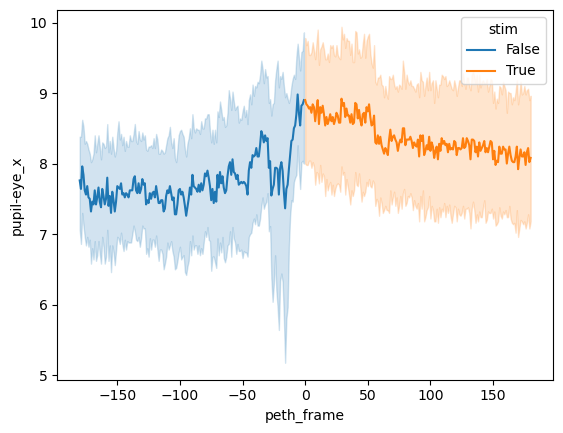

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
12,Left,1,34,34 L 20hz 5ms 5s.mp4,1,20.0,1,16000,17385.0,17684.0,59.94,1920,1080


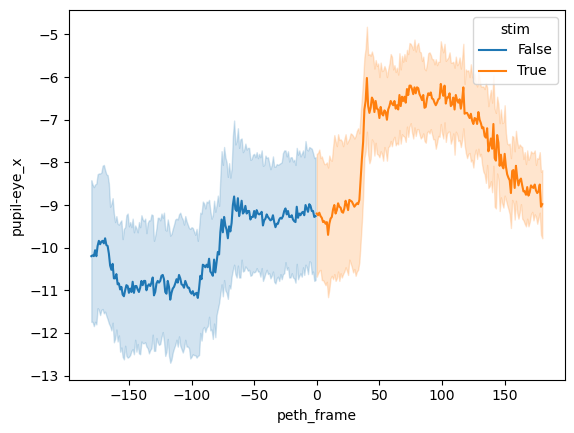

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
13,Right,1,34,34 R 20hz 5ms 5s.mp4,0,20.0,1,16000,17385.0,17684.0,59.94,1920,1080


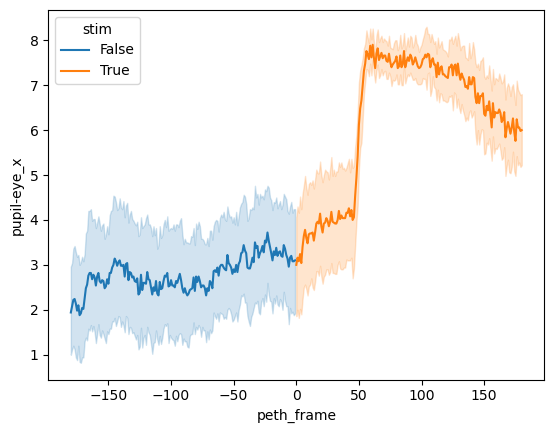

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
14,Left,1,38,38 L 20hz 5ms 5s.MP4,1,20.0,1,16000,35944.0,36240.0,59.94,1920,1080


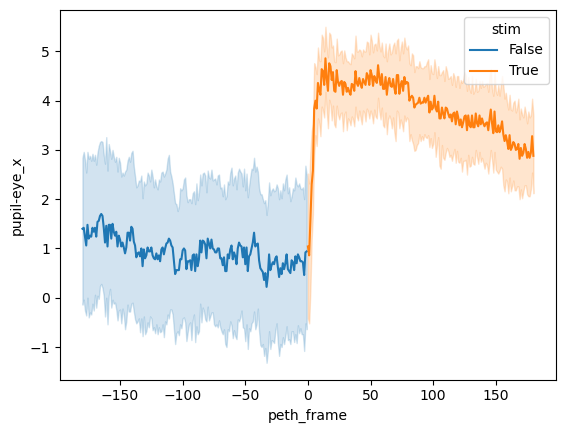

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
15,Right,1,38,38 R 20hz 5ms 5s.MP4,0,20.0,1,16000,30639.0,30937.0,59.94,1920,1080


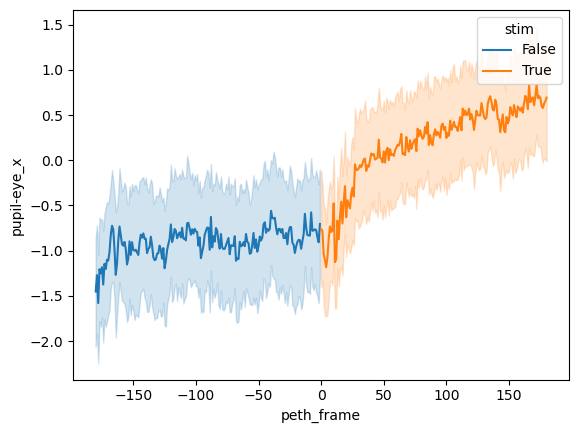

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
16,Left,1,40,40 L 20hz 5ms 5s.MP4,1,20.0,1,16000,25828.0,26126.0,59.94,1920,1080


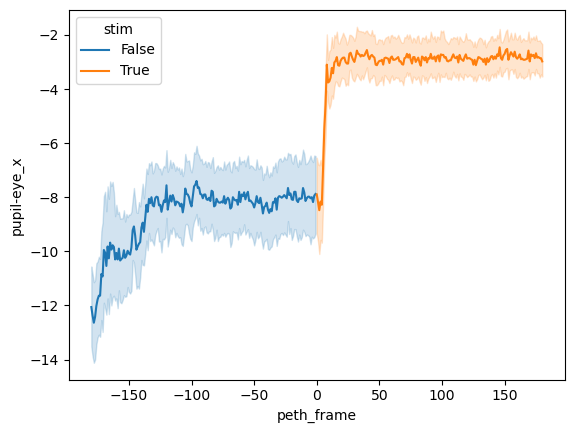

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
17,Right,1,40,40 R 20hz 5ms 5s.MP4,0,20.0,1,16000,24064.0,24362.0,59.94,1920,1080


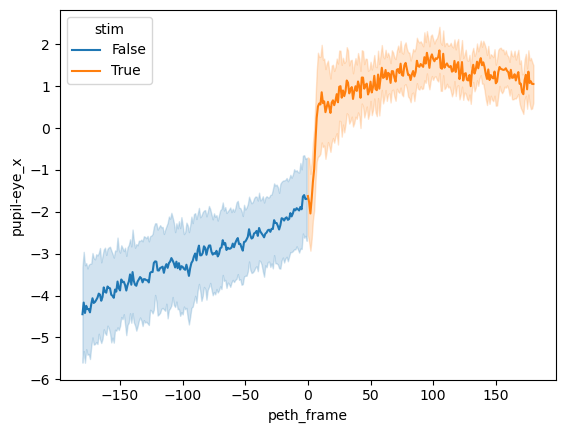

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
18,Left,1,42,42 L 20hz 5ms 5s.MP4,1,20.0,1,16000,26032.0,26331.0,59.94,1920,1080


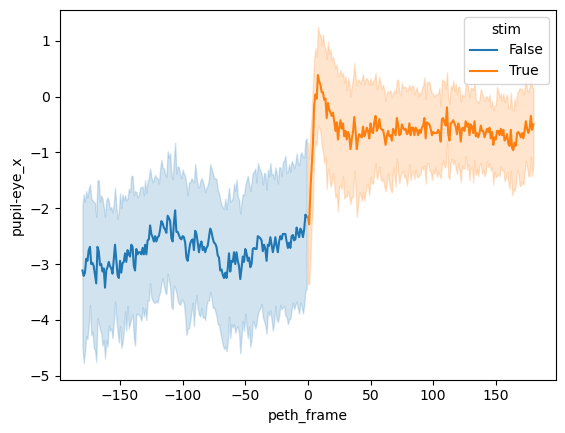

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
19,Right,1,42,42 R 20hz 5ms 5s.MP4,0,20.0,1,16000,22918.0,23217.0,59.94,1920,1080


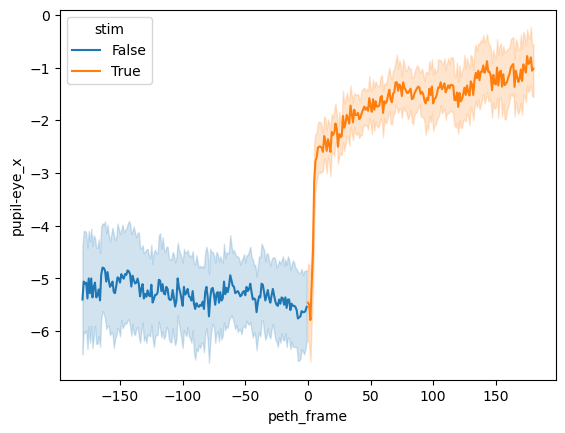

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
0,Left,0,60,60 L 20hz 5ms 5s.mp4,1,20.0,1,16000,23198.0,23497.0,59.94,1920,1080


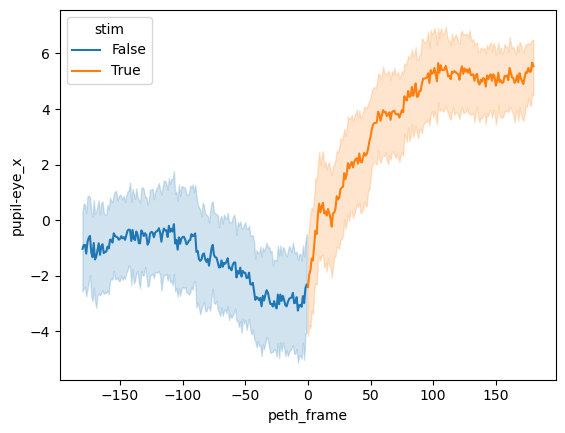

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
1,Right,0,60,60 R 20hz 5ms 5s.mp4,0,20.0,1,16000,28982.0,29280.0,59.94,1920,1080


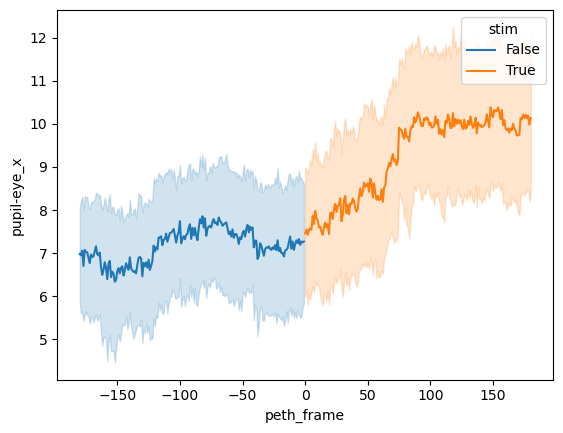

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
20,Left,0,61,61 L 20hz 5ms 5s.MP4,1,20.0,1,16000,31157.0,31456.0,59.94,1920,1080


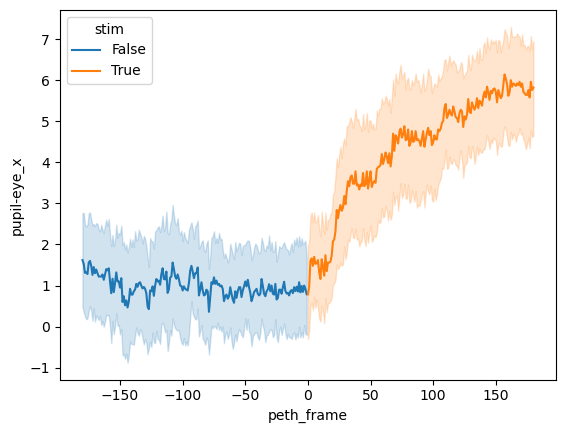

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
21,Right,0,61,61 R 20hz 5ms 5s.MP4,0,20.0,1,16000,26462.0,26761.0,59.94,1920,1080


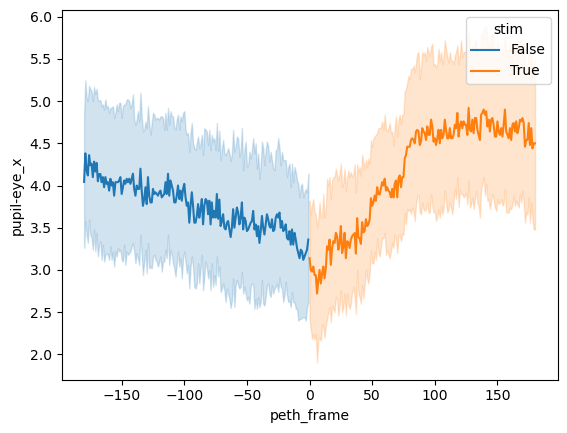

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
22,Left,0,62,62 L 20hz 5ms 5s.MP4,1,20.0,1,16000,51688.0,51986.0,59.94,1920,1080


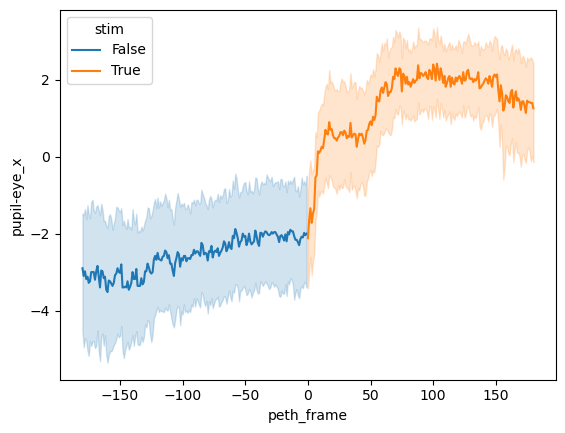

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
23,Right,0,62,62 R 20hz 5ms 5s.MP4,0,20.0,1,16000,28942.0,29240.0,59.94,1920,1080


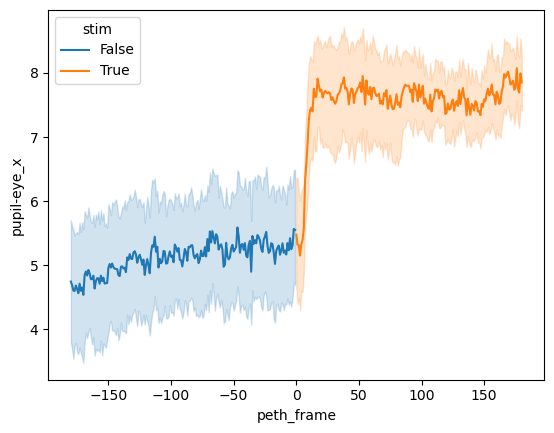

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
24,Left,0,63,63 L 20hz 5ms 5s.MP4,1,20.0,1,16000,29270.0,29568.0,59.94,1920,1080


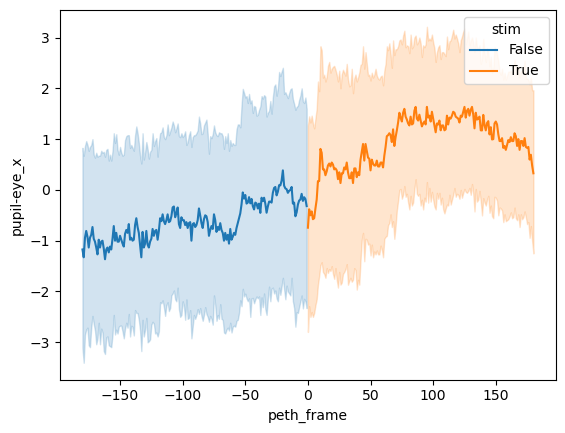

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
25,Right,0,63,63 R 20hz 5ms 5s.MP4,0,20.0,1,16000,29348.0,29646.0,59.94,1920,1080


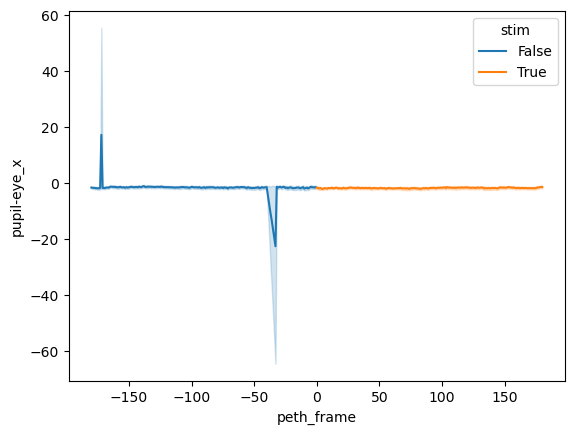

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
26,Left,0,64,64 L 20hz 5ms 5s.MP4,1,20.0,1,16000,29612.0,29910.0,59.94,1920,1080


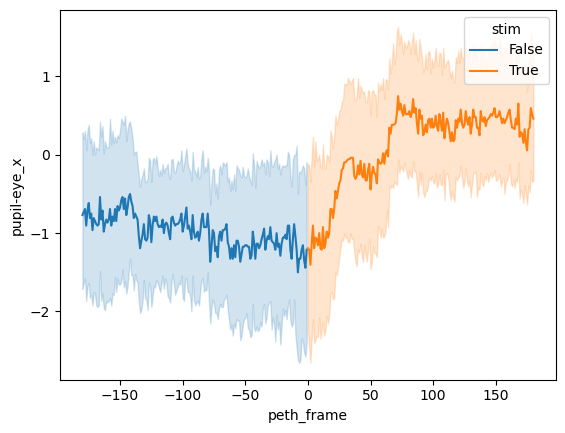

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
27,Right,0,64,64 R 20hz 5ms 5s.MP4,0,20.0,1,16000,25850.0,26148.0,59.94,1920,1080


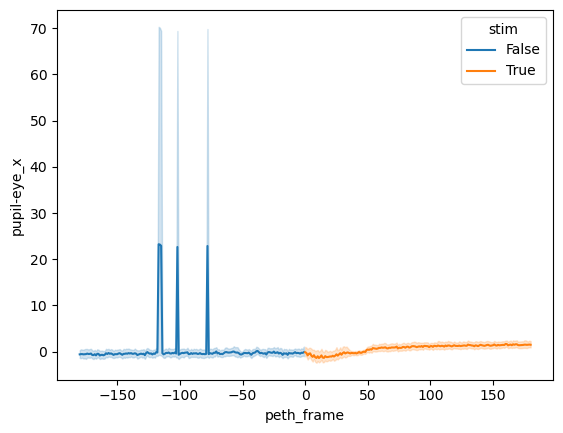

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
28,Left,0,66,66 L 20hz 5ms 5s.MP4,1,20.0,1,16000,28357.0,28656.0,59.94,1920,1080


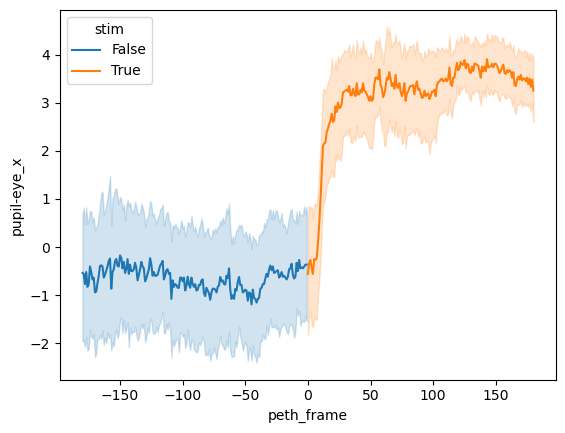

,Group,IsRostral,NumMouse,VideoName,IsLeftEye,Frequency,StartFrame,EndFrame,StimulationStartFrame,StimulationEndFrame,FPS,FrameWidth,FrameHeight
29,Right,0,66,66 R 20hz 5ms 5s.MP4,0,20.0,1,16000,25252.0,25550.0,59.94,1920,1080


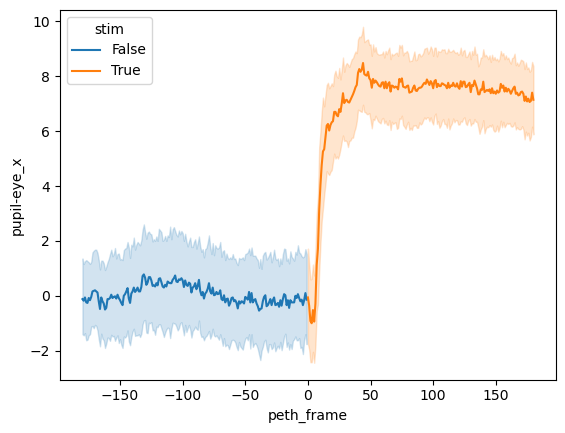

In [3]:
# save xlsx and png files
for _name in filenames:
    try:
        video1_name = _name
        mouse1 = LabelAnalysis(video_name=video1_name)
        mouse1.peth_to_xlsx()
        mouse1.save_peth_fig()
    except: 
        print(f'error: {video1_name}')

In [7]:
from scipy.stats import ttest_rel

## t-test
xlsx_path = r'C:\Users\jyc13\Documents\Python Scripts\openCV_eyemovement\analysis\result_xlsx\rostral4'
xlsx_files = os.listdir(xlsx_path)
lfiles = [x for x in xlsx_files if 'L 20hz' in x]
rfiles = [x for x in xlsx_files if 'R 20hz' in x]

except_lfiles = []
except_lfiles = [x+'.xlsx' for x in except_lfiles]
except_rfiles = []
except_rfiles = [x+'.xlsx' for x in except_rfiles]

lfiles = [x for x in lfiles if x not in except_lfiles]
rfiles = [x for x in rfiles if x not in except_rfiles]

def do_ttest(files):
    single_mouse = []
    for f in files:
        df = pd.read_excel(os.path.join(xlsx_path, f), engine='openpyxl')
        df = df.dropna().groupby(['stim'])[['pupil-eye_x']].mean()
        single_mouse.append(df)

    int_df = pd.concat(single_mouse)
    display(int_df)

    print(ttest_rel(int_df.xs(False), int_df.xs(True)))

# rostral
print('rostral')
do_ttest(lfiles)
do_ttest(rfiles)

# caudal
xlsx_path = r'C:\Users\jyc13\Documents\Python Scripts\openCV_eyemovement\analysis\result_xlsx\caudal4'
xlsx_files = os.listdir(xlsx_path)
lfiles = [x for x in xlsx_files if 'L 20hz' in x]
rfiles = [x for x in xlsx_files if 'R 20hz' in x]

except_lfiles = ['38 L 20hz 5ms 5s.MP4', '62 L 20hz 5ms 5s.MP4']
except_lfiles = [x+'.xlsx' for x in except_lfiles]
except_rfiles = ['38 R 20hz 5ms 5s.MP4', '62 R 20hz 5ms 5s.MP4']
except_rfiles = [x+'.xlsx' for x in except_rfiles]

lfiles = [x for x in lfiles if x not in except_lfiles]
rfiles = [x for x in rfiles if x not in except_rfiles]
print('caudal')
do_ttest(lfiles)
do_ttest(rfiles)


rostral


,pupil-eye_x
stim,
False,-9.362686
True,-8.205107
False,-8.715815
True,-9.149893
False,-10.074513
True,-7.544933
False,0.939217
True,3.837913
False,-8.626236


Ttest_relResult(statistic=array([-2.83948359]), pvalue=array([0.03626843]))


,pupil-eye_x
stim,
False,8.745414
True,12.213854
False,7.746328
True,8.374404
False,2.791456
True,6.211198
False,-0.905546
True,0.186011
False,-3.092541


Ttest_relResult(statistic=array([-4.50838536]), pvalue=array([0.00635032]))
caudal


,pupil-eye_x
stim,
False,-1.434716
True,3.745194
False,0.991031
True,4.339223
False,-0.627907
True,0.922742
False,-0.975665
True,0.101900
False,-0.645138


Ttest_relResult(statistic=array([-3.97803317]), pvalue=array([0.01642807]))


,pupil-eye_x
stim,
False,7.165569
True,9.252563
False,3.756745
True,4.165516
False,-1.990546
True,-1.849005
False,0.297502
True,0.695545
False,0.052670


Ttest_relResult(statistic=array([-1.55074239]), pvalue=array([0.19590273]))
